In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import datetime

from itertools import product

from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel

from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

/Users/danieltaber/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load data collected from Metacritic, IMDB, and Oscars.org
file = 'df_master_1992-2017_cleaned'
f = open(file,'rb') 
df = pickle.load(f) 
f.close()

In [3]:
df = df.dropna()
df = df.drop_duplicates(['imdb_name', 'imdb_year'])
len(df)

1900

In [ ]:
df_bp = df[df.bp_nominee == 1.0]
len(df_bp)

In [ ]:
df_noms = df[df.nominee == 1.0]
len(df_noms)

In [ ]:
df.winner.value_counts()

# Exploratory data analysis

Two sets of comparisons:  
* Best Picture nominees vs. other
* Best Picture winners vs. Best Picture nominees that didn't win

In [ ]:
df.groupby('bp_nominee')['log_gross_new_norm', 'metacritic_norm', 'runtime', 'log_total_wins_norm'].mean()

In [ ]:
df_bp.groupby('winner')['log_gross_new_norm', 'metacritic_norm', 'runtime', 'log_total_wins_norm'].mean()

In [ ]:
df.groupby('bp_nominee')['comedy', 'drama', 'mystery', 'family', 'sci-fi', 'musical',
                        'thriller', 'history', 'adventure', 'sport', 'biography', 'USA', 'UK', 'Winter'].mean()

In [ ]:
df_bp.groupby('winner')['comedy', 'drama', 'mystery', 'family', 'sci-fi', 'musical',
                        'thriller', 'history', 'adventure', 'sport', 'biography', 'USA', 'UK',  'Spring'].mean()

In [ ]:
bp_genre = pd.crosstab(df.Winter, df.bp_nominee)
winner_genre = pd.crosstab(df_bp.Winter, df_bp.winner)

ax = bp_genre.div(bp_genre.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
ax = winner_genre.div(winner_genre.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Best Picture by Season')
plt.xlabel('Winter')
plt.ylabel('Percentage')

# Functions

In [4]:
# Create a general classifer function
def train_score(classifier, x, y, test_size):
    mm = MinMaxScaler()
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=test_size, random_state=1234)
    xtrain = mm.fit_transform(xtrain)
    xtest = mm.transform(xtest)
    ytrain = np.ravel(ytrain)    
    clf = classifier.fit(xtrain, ytrain)    
    
    # score the model (accuracy)   
    train_acc = clf.score(xtrain, ytrain)
    test_acc = clf.score(xtest, ytest)
    
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    # create a confusion matrix
    y_true = ytest
    y_pred = clf.predict(xtest)   
    conf = confusion_matrix(y_true, y_pred)
    print ('\n')
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
    print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
    # ROC curve
    y_score = clf.predict_proba(xtest)[:,1]
    fpr, tpr, thresholds = roc_curve(ytest, y_score)
    roc_auc = auc(fpr, tpr)

    print('AUC: ', roc_auc)    

    plt.figure()
    plt.plot([0,1],[0,1]) # this is our baseline
    plt.plot(fpr, tpr) # this is our ROC curve
    plt.xlabel('FPR')
    plt.ylabel('TPR')

In [5]:
features = ['log_gross_new_norm', 'drama', 'comedy', 'action', 'crime', 'romance', 'sport', 'biography',
              'mystery', 'musical', 'thriller', 'adventure', 'sci-fi', 'family', 'history', 'USA', 'UK',
              'runtime', 'metacritic_norm', 'log_total_wins_norm', 'Winter', 'Spring']
y = df['bp_nominee']
X = df.loc[:, features]

In [ ]:
len(features)

In [ ]:
for var in features:
    print(df.groupby('bp_nominee')[var].mean())

# Models

Although the goal is to predict the Best Picture *winner*, the models are designed to reduce bias by predicting Best Picture *nominees*. The highest predicted probability of nomination will then be used as a proxy for the 'winner'.

8 different classifiers are used:  
* Logistic regression
* Naive Bayes
* KNN
* SVM
* Random forest
* Extra Trees
* Gradient boosting
* AdaBoost

### Logistic regression

Training Data Accuracy: 0.95
Test Data Accuracy:     0.96


[[350   0]
 [ 16  14]]


Precision:              1.00
Recall:                 0.47
AUC:  0.955904761905


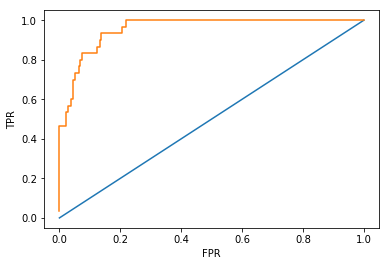

In [6]:
model_lr = LogisticRegression()

rfe_lr = RFE(model_lr, 20)
train_score(rfe_lr, X, y, 0.2)

# print ("Features sorted by their rank:")
# print (sorted(zip(map(lambda x: round(x, 4), rfe_lr.ranking_), features)))

### Naive Bayes

In [ ]:
model_Bayes = naive_bayes.BernoulliNB()
rfe_Bayes = RFE(model_Bayes, 20)
train_score(rfe_Bayes, X, y, 0.2)

print ("Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe_Bayes.ranking_), features)))

### KNN

In [ ]:
mm = MinMaxScaler()
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)
xtrain = mm.fit_transform(xtrain)
xtest = mm.transform(xtest)

In [ ]:
k_scores = []

for k in range(1, 20):

    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, xtrain, ytrain, cv=5, scoring='recall')
    
    k_scores.append((k, scores.mean()))
    
k_scores = pd.DataFrame(k_scores, columns=['k', 'recall']).set_index('k')
k_scores[k_scores.recall==max(k_scores.recall)]

In [ ]:
model_knn = KNeighborsClassifier(n_neighbors=1)
model_knn.fit(xtrain, ytrain)

y_pred = model_knn.predict(xtest)
y_score = model_knn.predict_proba(xtest)[:,1]
print(confusion_matrix(ytest, y_pred))
print(accuracy_score(ytest, y_pred))

### SVM

In [ ]:
mm = MinMaxScaler()
xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)

xtrain_sc = mm.fit_transform(xtrain)
xtest_sc = mm.transform(xtest)

param_grid = {'C': [1.0, 10., 100.],
              'degree':[2,3,4],
              'kernel':['rbf'],
              'gamma':[3,4]}

svm = GridSearchCV(SVC(), param_grid=param_grid)
svm.fit(xtrain_sc, ytrain)
y_pred = svm.predict(xtest_sc)
print(confusion_matrix(ytest, y_pred))
print(accuracy_score(ytest, y_pred))

### Random forests

In [ ]:
param_grid = {'n_estimators': [100, 200, 300, 400], 'n_jobs': [-1]}
model_rf = GridSearchCV(RandomForestClassifier(max_features = 20, max_depth = 3, random_state = 1234), 
                        param_grid=param_grid, 
                        cv=10, 
                        scoring='recall')
train_score(model_rf, X, y, 0.2)
print (model_rf.best_params_)

### Gradient boosting

In [ ]:
param_grid = {'n_estimators': [100, 200, 300, 400]}
model_gbt = GridSearchCV(GradientBoostingClassifier(max_features = 20, max_depth = 3, random_state = 1234), 
                         param_grid=param_grid, 
                         cv=10, 
                         scoring='recall')
train_score(model_gbt, X, y, 0.2)

### AdaBoost

In [ ]:
param_grid = {'n_estimators': [100, 200, 300, 400]}
model_ada = GridSearchCV(AdaBoostClassifier(random_state = 1234), 
                         param_grid=param_grid, 
                         cv=10, 
                         scoring='recall')
train_score(model_ada, X, y, 0.2)

### Extra trees classifier

Training Data Accuracy: 0.32
Test Data Accuracy:     0.33


[[349   1]
 [ 20  10]]


Precision:              0.91
Recall:                 0.33
AUC:  0.961047619048
{'n_estimators': 100}


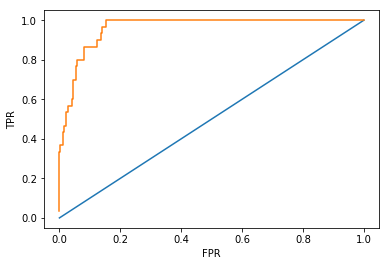

In [7]:
param_grid = {'n_estimators': [100, 200, 300, 400]}
model_ext = GridSearchCV(ExtraTreesClassifier(max_features = 20, max_depth = 3, random_state = 1234), 
                         param_grid=param_grid, 
                         cv=10, 
                         scoring='recall')
train_score(model_ext, X, y, 0.2)
print (model_ext.best_params_)

In [8]:
model_ext = ExtraTreesClassifier(max_features = 20, max_depth = 3, random_state = 1234, 
                        n_estimators = 100,
                        n_jobs = -1)

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

model_ext.fit(xtrain, ytrain)

importances = model_ext.feature_importances_
indices = np.argsort(importances)[::-1]

# for i in indices[:10]:
#     print (features[i], round(importances[i], 3))

# Apply model to the full dataset

In [9]:
param_grid = {'n_estimators': [100, 200, 300, 400]}

model = ExtraTreesClassifier(max_features = 20, max_depth = 3, random_state = 1234, 
                        n_estimators = 100,
                        n_jobs = -1)

lr = LogisticRegression()
model2 = RFE(lr, 20)

In [10]:
model.fit(X, y)
model2.fit(X, y)

#df['y_pred'] = model2.predict(X)
df['y_pred_prob1'] = model.predict_proba(X)[:,1]
df['y_pred_prob2'] = model2.predict_proba(X)[:,1]

df['y_pred_prob_ensem'] = (df['y_pred_prob1'] + df['y_pred_prob2'])/2

In [ ]:
# Calculate the max probability by year to flag the 'winner'
pred_winners = df.loc[df.groupby('oscar_year')['y_pred_prob_ensem'].idxmax(),['imdb_name']]
pred_winners['pred_winner'] = 1.0
results = pd.merge(df, pred_winners, on='imdb_name', how='outer')
results['pred_winner'].fillna(0, inplace = True)

In [ ]:
print(confusion_matrix(results['winner'], results['pred_winner']))
print(accuracy_score(results['winner'], results['pred_winner']))

# Explore the results

Examine which movies were classified correctly and which were classified incorrectly

**Which Best Picture winners were categorized correctly?**

In [ ]:
results.loc[(results['winner'] == 1.0) & (results['pred_winner'] == 1.0)]

**Which Best Picture winners were categorized incorrectly?**

In [ ]:
results.loc[(results['winner'] == 1.0) & (results['pred_winner'] == 0.0)]

**Which were the "snubs"?**

In [ ]:
results.loc[(results['winner'] == 0.0) & (results['pred_winner'] ==1.0)]

**What was the biggest snub ever?**

In [ ]:
i = results.loc[(results['winner'] == 0.0) & (results['pred_winner'] == 1.0)].y_pred_prob_ensem.idxmax()

print("The biggest Best Picture snub in the last 25 years:")
print('\n')
print('\t' + results['imdb_name'][i])

In [ ]:
# Export the final results
results.to_csv('final results.csv')

# 2018 results

In [11]:
file = 'df_bp_2018'
f = open(file,'rb') 
df = pickle.load(f)
f.close()

In [12]:
X = df.loc[:, features]

In [13]:
df['y_pred_prob1'] = model.predict_proba(X)[:,1]
df['y_pred_prob2'] = model2.predict_proba(X)[:,1]

df['y_pred_prob_ensem'] = (df['y_pred_prob1'] + df['y_pred_prob2'])/2

In [14]:
winner = df.loc[df['y_pred_prob_ensem'].idxmax(),['imdb_name']]

In [15]:
print("My final prediction for the 2018 Best Picture winner:")
print('\n')
print('\t' + winner['imdb_name'].upper())
print('\n')
print('Recorded at: ' + str(datetime.datetime.now()))

My final prediction for the 2018 Best Picture winner:


	GET OUT


Recorded at: 2018-03-04 11:48:59.040178
